In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---ファイルの読み込むパスを指定---
file_path_left_device = "WearableDevices/oba_l_left_foot_data.csv"
file_path_right_device = "WearableDevices/oba_l_right_foot_data.csv"
file_path_mocap = "MotionCaptures/oba_l_mocap.csv"
file_path_force = "3DGroundForces/oba_l_force.csv"

# ---CSVファイルの読み込み---
df_left_device = pd.read_csv(file_path_left_device, header=0)
df_right_device = pd.read_csv(file_path_right_device, header=0)
df_mocap = pd.read_csv(file_path_mocap, header=[2, 5, 6])
df_force = pd.read_csv(file_path_force, header=10, encoding='shift_jis')

In [144]:
"""
# ---モーションキャプチャデータの列名を整理---
"""
new_columns = []

for col in df_mocap.columns:
    # col[0]: Rigid Body 001, col[1]: Position, col[2]: X
    
    # 1. FrameとTimeはそのまま
    if col[2] == 'Frame':
        new_columns.append('Frame')
    elif 'Time' in col[2]:
        new_columns.append('Time (Seconds)')
        
    # 2. それ以外は "Rigid Body " を削除して番号だけにする
    else:
        # "Rigid Body " を空文字に置換し、前後の空白も削除
        body_num = col[0].replace('Rigid Body', '').strip()
        
        # 例: 001_Position_X
        name = f"{body_num}_{col[1]}_{col[2]}"
        new_columns.append(name)

# 列名を更新
df_mocap.columns = new_columns

print(df_mocap.columns)

Index(['Frame', 'Time (Seconds)', '001_Rotation_X', '001_Rotation_Y',
       '001_Rotation_Z', '001_Position_X', '001_Position_Y', '001_Position_Z',
       '002_Rotation_X', '002_Rotation_Y', '002_Rotation_Z', '002_Position_X',
       '002_Position_Y', '002_Position_Z', '003_Rotation_X', '003_Rotation_Y',
       '003_Rotation_Z', '003_Position_X', '003_Position_Y', '003_Position_Z',
       '004_Rotation_X', '004_Rotation_Y', '004_Rotation_Z', '004_Position_X',
       '004_Position_Y', '004_Position_Z', '006_Rotation_X', '006_Rotation_Y',
       '006_Rotation_Z', '006_Position_X', '006_Position_Y', '006_Position_Z',
       '007_Rotation_X', '007_Rotation_Y', '007_Rotation_Z', '007_Position_X',
       '007_Position_Y', '007_Position_Z', '008_Rotation_X', '008_Rotation_Y',
       '008_Rotation_Z', '008_Position_X', '008_Position_Y', '008_Position_Z',
       '009_Rotation_X', '009_Rotation_Y', '009_Rotation_Z', '009_Position_X',
       '009_Position_Y', '009_Position_Z', '010_Rotation_X', 

In [145]:
"""
# ---地面反力データの列名を整理---
"""
columns_mapping = {
    'Unnamed: 0': 'Time (Seconds)',
    '右-Fx': 'R_Fx',
    '右-Fy': 'R_Fy',
    '右-Fz': 'R_Fz',
    '右-Mx': 'R_Mx',
    '右-My': 'R_My',
    '右-Mz': 'R_Mz',
    '右-COPx': 'R_COPx',
    '右-COPy': 'R_COPy',
    '左-Fx': 'L_Fx',
    '左-Fy': 'L_Fy',
    '左-Fz': 'L_Fz',
    '左-Mx': 'L_Mx',
    '左-My': 'L_My',
    '左-Mz': 'L_Mz',
    '左-COPx': 'L_COPx',
    '左-COPy': 'L_COPy',
    '右-速度計': 'R_SpeedMeter',
    '左-速度計': 'L_SpeedMeter',
    '右-外部制御': 'R_ExtControl',
    '左-外部制御': 'L_ExtControl',
    '右-速度': 'R_Speed',
    '左-速度': 'L_Speed',
    '右-実速度': 'R_ActualSpeed',
    '左-実速度': 'L_ActualSpeed',
    '右-実効負荷率': 'R_EffLoadRatio',
    '右-ピーク負荷率': 'R_PeakLoadRatio',
    '右-消費電力': 'R_Power',
    '左-実効負荷率': 'L_EffLoadRatio',
    '左-ピーク負荷率': 'L_PeakLoadRatio',
    '左-消費電力': 'L_Power',
    'アナログ入力1': 'Analog1'
}

df_force = df_force.rename(columns=columns_mapping)
print(df_force.columns)

Index(['Time (Seconds)', 'R_Fx', 'R_Fy', 'R_Fz', 'R_Mx', 'R_My', 'R_Mz',
       'R_COPx', 'R_COPy', 'L_Fx', 'L_Fy', 'L_Fz', 'L_Mx', 'L_My', 'L_Mz',
       'L_COPx', 'L_COPy', 'R_SpeedMeter', 'L_SpeedMeter', 'R_ExtControl',
       'L_ExtControl', 'R_Speed', 'L_Speed', 'R_ActualSpeed', 'L_ActualSpeed',
       'R_EffLoadRatio', 'R_PeakLoadRatio', 'R_Power', 'L_EffLoadRatio',
       'L_PeakLoadRatio', 'L_Power', 'Analog1'],
      dtype='object')


In [146]:
from scipy.interpolate import interp1d

def process_resampling(df_input, sampling_interval=10):
    """
    データフレームを受け取り、リサンプリングと単位変換を行って返す関数
    """
    # 元のデータを変更しないようにコピーを作成
    df = df_input.copy()

    # --- 1. 欠損値の補完（リサンプリング前） ---
    # Marker列を除外して線形補完
    exclude_cols = ['Marker']
    target_cols = df.columns.difference(exclude_cols)
    
    # 補完処理
    df[target_cols] = df[target_cols].interpolate(method='linear', axis=0)

    # --- 2. 新しい時間軸の作成 (100Hz = 10ms) ---
    time_min = 0
    time_max = df['ElapsedTime'].max()
    new_time = np.arange(time_min, time_max, sampling_interval)
    
    # 新しい時間軸を持つDataFrameを作成
    df_resampled = pd.DataFrame({'ElapsedTime': new_time})

    # --- 3. マーカー列（不連続データ）の処理 ---
    # マーカー列が存在する場合のみ処理を行う
    if exclude_cols:
        df_markers = df[['ElapsedTime'] + exclude_cols].dropna(subset=exclude_cols, how='all').copy()
        
        # マーカーのタイミングを新しいサンプリングレートのグリッドに丸める
        df_markers['ElapsedTime_rounded'] = (df_markers['ElapsedTime'] / sampling_interval).round() * sampling_interval
        # 同じタイミングに重複した場合の処理（重複削除）
        df_markers = df_markers.drop_duplicates(subset=['ElapsedTime_rounded'])
        
        # 結合用のキーを作成 (整数化して浮動小数点の誤差を回避)
        df_resampled['MergeKey'] = df_resampled['ElapsedTime'].round().astype(int)
        df_markers['MergeKey'] = df_markers['ElapsedTime_rounded'].round().astype(int)
        
        # マーカー情報を結合
        df_resampled = pd.merge(
            df_resampled,
            df_markers[['MergeKey'] + exclude_cols],
            left_on='MergeKey',
            right_on='MergeKey',
            how='left'
        )
        # 不要なキーを削除
        df_resampled = df_resampled.drop(columns=['MergeKey'])

    # --- 4. 連続値データの補間 (interp1d) ---
    # 補間から除外するカラム（時間とマーカー）
    columns_to_exclude = ['ElapsedTime'] + exclude_cols
    
    for column in df.columns:
        if column in columns_to_exclude:
            continue
        
        # interp1dによる線形補間関数作成 (外挿あり)
        interpolator = interp1d(df['ElapsedTime'], df[column], 
                                kind='linear', 
                                fill_value='extrapolate')
        
        # 新しい時間軸で値を計算して代入
        df_resampled[column] = interpolator(new_time)

    # --- 5. 単位変換とリネーム ---
    # ms -> s
    df_resampled['ElapsedTime'] = df_resampled['ElapsedTime'] / 1000
    # カラム名変更
    df_resampled = df_resampled.rename(columns={'ElapsedTime': 'Time (Seconds)'})

    return df_resampled

# 関数を適用して左右それぞれ処理
df_left_processed = process_resampling(df_left_device, sampling_interval=10)
df_right_processed = process_resampling(df_right_device, sampling_interval=10)

# 結果の確認
print("Left Data Columns:", df_left_processed.columns)
print("Right Data Columns:", df_right_processed.columns)
print(df_left_processed.head())

Left Data Columns: Index(['Time (Seconds)', 'Marker', 'Left_kPa_1', 'Left_kPa_2', 'Left_kPa_3',
       'Left_kPa_4', 'Left_kPa_5', 'Left_kPa_6', 'Left_kPa_7', 'Left_kPa_8',
       'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z', 'Left_Gyro_X',
       'Left_Gyro_Y', 'Left_Gyro_Z'],
      dtype='object')
Right Data Columns: Index(['Time (Seconds)', 'Marker', 'Right_kPa_1', 'Right_kPa_2', 'Right_kPa_3',
       'Right_kPa_4', 'Right_kPa_5', 'Right_kPa_6', 'Right_kPa_7',
       'Right_kPa_8', 'Right_Accel_X', 'Right_Accel_Y', 'Right_Accel_Z',
       'Right_Gyro_X', 'Right_Gyro_Y', 'Right_Gyro_Z'],
      dtype='object')
   Time (Seconds)  Marker  Left_kPa_1  Left_kPa_2  Left_kPa_3  Left_kPa_4  \
0            0.00     NaN    2.383994    1.826595    7.341202    8.748256   
1            0.01     NaN    2.604705    1.826595    7.817701    8.225619   
2            0.02     NaN    3.038397    1.606759    7.951121    7.969418   
3            0.03     NaN    2.946065    1.533481    7.484152    8.2252

In [147]:
from scipy import signal

# --- 設定パラメータ ---
DEVICE_FREQ = 100          # デバイスのサンプリング周波数 (Hz)
CUTOFF_FREQ = 6            # ローパスフィルタのカットオフ周波数 (Hz)
FILTER_ORDER = 4           # フィルタの次数

def apply_lowpass_filter(data, cutoff, fs, order=4):
    """
    Butterworthローパスフィルタを適用するヘルパー関数
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

def process_smoothing_dataframe(df_input, fs=DEVICE_FREQ, cutoff=CUTOFF_FREQ, order=FILTER_ORDER):
    """
    1. TimeとMarker以外の全カラムにフィルタをかける
    2. 'kPa' を含むカラム（圧力）だけ、マイナス値を0に補正する
    """
    df_smooth = df_input.copy()
    
    # --- 1. 平滑化対象のカラムを特定 (Time, Marker以外すべて) ---
    exclude_keywords = ['Time (Seconds)', 'Marker']
    # フィルタ対象：TimeやMarkerを含まない全てのカラム（IMUデータ含む）
    filter_target_cols = [
        col for col in df_smooth.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 欠損値の補完 & フィルタ実行 ---
    # 欠損があるとフィルタできないため補完
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].interpolate(method='linear', limit_direction='both')
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].fillna(0)

    # フィルタ適用 (IMUも圧力もここで滑らかになります)
    df_smooth[filter_target_cols] = apply_lowpass_filter(
        df_smooth[filter_target_cols].values, 
        cutoff=cutoff, 
        fs=fs, 
        order=order
    )
    
    # --- 3. 圧力データのみマイナス値を0にする (クリッピング) ---
    # カラム名に 'kPa' が含まれるものだけを抽出 (例: Right_kPa_1, Left_kPa_8 など)
    pressure_cols = [col for col in filter_target_cols if 'kPa' in col]
    
    if pressure_cols:
        # 該当するカラムのデータを取り出し、0未満を0にする
        df_pressure = df_smooth[pressure_cols]
        df_smooth[pressure_cols] = df_pressure.mask(df_pressure < 0, 0)
    
    return df_smooth

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用
df_left_smoothed = process_smoothing_dataframe(df_left_processed)
df_right_smoothed = process_smoothing_dataframe(df_right_processed)
df_mocap_smoothed =process_smoothing_dataframe(df_mocap, 250)
df_force_smoothed =process_smoothing_dataframe(df_force, 1000)

In [148]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# ============================================================
#  設定・定数定義
# ============================================================
R_ILIUM_INDEX               = 1
R_GREATER_TROCHANTER_INDEX  = 2
R_KNEE_INDEX                = 3
R_MALLEOLUS_INDEX           = 4
R_TOE_INDEX                 = 5
L_ILIUM_INDEX               = 6
L_GREATER_TROCHANTER_INDEX  = 7
L_KNEE_INDEX                = 8
L_MALLEOLUS_INDEX           = 9
L_TOE_INDEX                 = 10

JOINT_NO = 6

class CalculateAngle:
    """
    角度計算クラス
    """
    @staticmethod
    def _vec(A, B, C):
        return np.stack((A - B, C - B), axis=0)

    @staticmethod
    def _angle2d(a, b):
        inner = np.dot(a, b)
        norm_a = LA.norm(a)
        norm_b = LA.norm(b)
        
        # ---------------------------------------------------------
        # 【修正点】特異点対策 (Drift Prevention)
        # ---------------------------------------------------------
        # ベクトルの長さが極端に短い場合（ノイズレベル）は計算しない
        # これにより、0度と360度の境界での激しい振動を防ぎ、
        # unwrapによる誤った積算（ドリフト）を回避します。
        if norm_a < 1e-4 or norm_b < 1e-4:
            return 0.0
        # ---------------------------------------------------------

        norm = norm_a * norm_b
        return np.degrees(np.arccos(np.clip(inner / norm, -1, 1)))

    def _angle3d(self, v):
        deg   = np.zeros(3)
        pairs = [
            (slice(None, 2),            0), # XY
            (slice(1, None),            1), # YZ
            ((2, 0),                    2)  # ZX
        ]
        
        for i, (sl, _) in enumerate(pairs):
            a = v[0][sl] if isinstance(sl, slice) else v[0][list(sl)]
            b = v[1][sl] if isinstance(sl, slice) else v[1][list(sl)]
            S = 0.5 * (b[0] * a[1] - b[1] * a[0])  
            ang = self._angle2d(a, b)
            deg[i] = 360 - ang if S < 0 else ang
        return deg

    def angles(self, pos):
        pos = pos[:, [0, 2, 1]].copy() 
        pos[:, 0] *= -1           
        out = np.zeros((JOINT_NO, 3))
        idxs = [
            (R_ILIUM_INDEX - 1, R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1),
            (L_ILIUM_INDEX - 1, L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1),
            (R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1),
            (L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1),
            (R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1, R_TOE_INDEX - 1),
            (L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1, L_TOE_INDEX - 1),
        ]
        for i, (a, b, c) in enumerate(idxs):
            out[i] = self._angle3d(self._vec(pos[a], pos[b], pos[c]))
        return out

# ============================================================
#  メイン処理
# ============================================================

def calculate_angles_from_positions(df, target_cols):
    """
    データフレームから角度計算を行うヘルパー関数
    """
    calculator = CalculateAngle()
    
    positions_flat = df[target_cols].values
    n_frames = positions_flat.shape[0]
    
    if n_frames == 0:
        return np.empty((0, 18))
        
    positions_3d = positions_flat.reshape(n_frames, 10, 3)
    
    all_angles = []
    for frame_idx in range(n_frames):
        current_pos = positions_3d[frame_idx]
        angles = calculator.angles(current_pos)
        all_angles.append(angles.flatten())
    
    return np.array(all_angles)

def process_mocap_data_target_calibration(df_target, df_ref):
    """
    df_target: 解析対象・計算対象 (250Hz)
    df_ref: タイミング特定用 (Marker情報あり)
    戻り値: df_result, base_pose_mean, columns
    """
    
    # 共通のカラム定義
    target_cols = []
    for i in range(1, 11):
        prefix = f"{i:03}"
        target_cols.extend([f"{prefix}_Position_X", f"{prefix}_Position_Y", f"{prefix}_Position_Z"])

    # --------------------------------------------------------
    # 1. タイミングの特定 (df_ref を使用)
    # --------------------------------------------------------
    print("キャリブレーション時間を特定中 (from df_ref)...")
    
    trigger_rows = df_ref[df_ref['Marker'] == 2]
    
    if trigger_rows.empty:
        raise ValueError("df_ref に Marker == 2 のデータが見つかりません．")
    
    # トリガー時刻を取得
    trigger_time = trigger_rows.iloc[0]['Time (Seconds)']
    print(f"トリガー検知時刻: {trigger_time:.4f} sec")
    
    # 時間ウィンドウ (20秒前 〜 15秒前)
    start_time = trigger_time - 20.0
    end_time   = trigger_time - 15.0
    
    print(f"基準区間時刻: {start_time:.2f} 〜 {end_time:.2f} sec")

    # --------------------------------------------------------
    # 2. 基準姿勢データの抽出 (df_target を使用)
    # --------------------------------------------------------
    mask = (df_target['Time (Seconds)'] >= start_time) & (df_target['Time (Seconds)'] <= end_time)
    df_base_window = df_target.loc[mask].copy()
    
    print(f"基準区間データ数 (df_target): {len(df_base_window)} frames")
    
    if len(df_base_window) == 0:
         raise ValueError(f"df_target内に指定時間({start_time:.2f}-{end_time:.2f})のデータが存在しません．")

    # --------------------------------------------------------
    # 3. 基準姿勢の計算 (平均)
    # --------------------------------------------------------
    ref_angles_continuous = calculate_angles_from_positions(df_base_window, target_cols)
    base_pose_mean = np.mean(ref_angles_continuous, axis=0) # shape (18,)

    # --------------------------------------------------------
    # 4. 全データの計算と補正 (Target - Base Pose)
    # --------------------------------------------------------
    print("全フレームの角度計算と補正中...")
    target_angles_continuous = calculate_angles_from_positions(df_target, target_cols)
    
    # 補正実行
    relative_angles = target_angles_continuous - base_pose_mean

    # DataFrame作成
    joint_names = ["R_Hip", "L_Hip", "R_Knee", "L_Knee", "R_Ankle", "L_Ankle"]
    plane_names = ["XY", "YZ", "ZX"]
    columns = []
    for joint in joint_names:
        for plane in plane_names:
            columns.append(f"{joint}_{plane}")
            
    df_result = pd.DataFrame(relative_angles, columns=columns)
    
    # Time, Frame列の結合
    if 'Time (Seconds)' in df_target.columns:
        df_result.insert(0, 'Time (Seconds)', df_target['Time (Seconds)'])
        
    # 基本姿勢の平均値とカラム名も返す
    return df_result, base_pose_mean, columns

# ============================================================
#  実行と表示
# ============================================================
try:
    # 戻り値を3つ受け取るように変更
    df_angles, base_pose_vals, angle_cols = process_mocap_data_target_calibration(df_mocap_smoothed, df_left_smoothed)
    
    print("計算完了:")
    print(df_angles.head())
    
    print("-" * 50)
    print("【基本姿勢の角度 (Calibration Mean)】")
    
    # 見やすくするためにDataFrame化して表示
    df_base_pose = pd.DataFrame(base_pose_vals.reshape(1, -1), columns=angle_cols, index=["BaseAngle (deg)"])
    
    # 横長になりがちなので転置して表示するか、そのまま表示するか選べます
    print(df_base_pose.T) # 転置して表示（関節名が行に来る）

except Exception as e:
    print(f"エラーが発生しました: {e}")
    import traceback
    traceback.print_exc()

キャリブレーション時間を特定中 (from df_ref)...
トリガー検知時刻: 30.0600 sec
基準区間時刻: 10.06 〜 15.06 sec
基準区間データ数 (df_target): 1250 frames
全フレームの角度計算と補正中...
計算完了:
   Time (Seconds)    R_Hip_XY   R_Hip_YZ  R_Hip_ZX    L_Hip_XY   L_Hip_YZ  \
0           0.000 -153.838522 -13.463013  7.954678  119.291105 -17.403362   
1           0.004 -153.840015 -13.462760  7.955949  119.289363 -17.400611   
2           0.008 -153.841428 -13.462453  7.957221  119.287680 -17.397870   
3           0.012 -153.842751 -13.462093  7.958476  119.286070 -17.395175   
4           0.016 -153.843973 -13.461687  7.959702  119.284547 -17.392560   

    L_Hip_ZX  R_Knee_XY  R_Knee_YZ  R_Knee_ZX  L_Knee_XY  L_Knee_YZ  \
0 -12.217091  77.107863  -4.640207  -0.300939 -47.133101  -7.559431   
1 -12.216435  77.104689  -4.641085  -0.299850 -47.131421  -7.558203   
2 -12.215823  77.101515  -4.641987  -0.298799 -47.129634  -7.556981   
3 -12.215244  77.098381  -4.642901  -0.297795 -47.127739  -7.555785   
4 -12.214690  77.095319  -4.643813  -0.2968

In [149]:
columns = ['Time (Seconds)', 'R_Fx', 'R_Fy', 'R_Fz', 'L_Fx', 'L_Fy', 'L_Fz']
force_columns = ['R_Fx', 'R_Fy', 'R_Fz', 'L_Fx', 'L_Fy', 'L_Fz']

body_weight = 60.9 * 9.81  # body weight [N]

df_normalized = df_force_smoothed[columns].copy()
df_normalized[force_columns] /= body_weight

print(df_normalized.head())


   Time (Seconds)      R_Fx      R_Fy      R_Fz      L_Fx      L_Fy      L_Fz
0           0.000  0.001666 -0.000034  0.001191 -0.000432 -0.000755 -0.002242
1           0.001  0.001677 -0.000039  0.001161 -0.000479 -0.000744 -0.002212
2           0.002  0.001688 -0.000045  0.001131 -0.000525 -0.000733 -0.002183
3           0.003  0.001698 -0.000051  0.001101 -0.000572 -0.000721 -0.002154
4           0.004  0.001709 -0.000056  0.001072 -0.000618 -0.000710 -0.002124


In [150]:
def process_zscore_normalization(df_input, duration=300):
    """
    マーカー出現（”2”）タイミングから指定時間(duration秒)のデータを用いて
    平均・標準偏差を算出し、Zスコア化を行う関数。
    """
    df_z = df_input.copy()
    
    # --- 1. 計算対象カラムの特定 ---
    # Time, Marker 以外を計算対象とする
    exclude_keywords = ['Time (Seconds)', 'Marker']
    target_cols = [
        col for col in df_z.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 基準となる期間（マーカー開始〜300秒）の特定 ---
    # マーカー列（Marker_xなど）を探す
    marker_cols = [col for col in df_z.columns if 'Marker' in col]
    
    start_time = 0
    if marker_cols:
        # マーカー列のいずれかが「2」である行を抽出
        # any(axis=1) は、複数のマーカー列がある場合に、少なくとも1つが2であればTrueとします
        marker_2_rows = df_z[ (df_z[marker_cols] == 2).any(axis=1) ]
        
        if not marker_2_rows.empty:
            # 最初に「2」が現れた行のTimeを取得
            start_time = marker_2_rows.iloc[0]['Time (Seconds)']
            print(f"Marker '2' found at: {start_time:.2f} s")
        else:
            print("Warning: Marker value '2' not found. Using start time = 0 s")
    
    end_time = start_time + duration
    
    # 統計量算出用のデータをスライス（抽出）
    # start_time <= Time <= end_time の範囲
    mask = (df_z['Time (Seconds)'] >= start_time) & (df_z['Time (Seconds)'] <= end_time)
    df_stats_base = df_z.loc[mask, target_cols]
    
    print(f"Statistics calculated range: {start_time:.1f}s - {end_time:.1f}s (Rows: {len(df_stats_base)})")

    # --- 3. 平均・標準偏差の算出 ---
    means = df_stats_base.mean()
    stds = df_stats_base.std()
    
    # --- 4. Zスコア化の実行 ---
    # 標準偏差が0の場合（ずっと値が変わらない場合）、割り算で無限大(inf)になるのを防ぐ
    # stdが0の場合は1に置換して、結果(x-mean)を0にする
    stds = stds.replace(0, 1)
    
    # 計算: (値 - 平均) / 標準偏差
    df_z[target_cols] = (df_z[target_cols] - means) / stds
    
    return df_z, means, stds

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用 (平滑化済みのデータを使用)
print("--- Processing Left Device ---")
df_left_z, left_means, left_stds = process_zscore_normalization(df_left_smoothed, duration=300)

print("\n--- Processing Right Device ---")
df_right_z, right_means, right_stds = process_zscore_normalization(df_right_smoothed, duration=300)

# 結果確認
print("\nTransformation Complete.")
df_left_z.head()

--- Processing Left Device ---
Marker '2' found at: 30.06 s
Statistics calculated range: 30.1s - 330.1s (Rows: 30001)

--- Processing Right Device ---
Marker '2' found at: 30.07 s
Statistics calculated range: 30.1s - 330.1s (Rows: 30001)

Transformation Complete.


,Time (Seconds),Marker,Left_kPa_1,Left_kPa_2,Left_kPa_3,Left_kPa_4,Left_kPa_5,Left_kPa_6,Left_kPa_7,Left_kPa_8,Left_Accel_X,Left_Accel_Y,Left_Accel_Z,Left_Gyro_X,Left_Gyro_Y,Left_Gyro_Z
0,0.00,NaN,-0.468661,-0.240646,1.164928,-0.167150,-0.419488,0.149367,-0.273942,-0.572567,0.162791,-0.659810,0.136243,-0.000875,-0.139314,-0.011927
1,0.01,NaN,-0.464329,-0.268121,1.168970,-0.181769,-0.410994,0.153724,-0.272252,-0.563202,0.111234,-0.719509,0.001950,-0.000892,-0.137851,-0.012266
2,0.02,NaN,-0.459965,-0.293940,1.172106,-0.195305,-0.403280,0.157590,-0.270625,-0.554242,0.063792,-0.774485,-0.121736,-0.000906,-0.136541,-0.012569
3,0.03,NaN,-0.455611,-0.316793,1.174047,-0.206739,-0.396944,0.160701,-0.269152,-0.546081,0.024107,-0.820548,-0.225414,-0.000912,-0.135487,-0.012811
4,0.04,NaN,-0.451323,-0.335557,1.174687,-0.215338,-0.392418,0.162877,-0.267866,-0.539032,-0.005047,-0.854503,-0.301910,-0.000905,-0.134763,-0.012967


In [151]:
def synchronize_and_merge_data(df_left, df_right, df_angles, df_force, target_freq=100):
    """
    時間軸の同期を行い、指定された周波数(target_freq)ですべてのデータを結合する関数
    
    条件:
    - Left/Right Device & Mocap: 同時開始 (t=0が一致)
    - Force Plate: Deviceの Marker "1" の時刻に開始
    """
    
    # --- 1. 同期タイミング(オフセット)の取得 ---
    trigger_marker = 1
    marker_rows = df_left_processed[df_left_processed['Marker'] == trigger_marker]
    
    offset_time = 0.0
    if not marker_rows.empty:
        offset_time = marker_rows.iloc[0]['Time (Seconds)']
        print(f"Synchronization Offset found: {offset_time:.4f} sec (Trigger: Marker {trigger_marker})")
    else:
        print(f"Warning: Marker {trigger_marker} not found. Assuming Offset = 0.0 sec")

    # --- 2. 床反力データの時間軸シフト ---
    # コピーを作成して時間をずらす
    df_force_synced = df_force.copy()
    df_force_synced['Time (Seconds)'] = df_force_synced['Time (Seconds)'] + offset_time
    
    print(f"Force Data Start Time shifted to: {df_force_synced['Time (Seconds)'].iloc[0]:.4f} sec")

    # --- 3. 統合用マスター時間軸の作成 ---
    # 全データの最小・最大時間を考慮して共通の時間軸を作成
    # 開始時刻はすべてのデータの開始時刻の最大値（すべてのデータが揃った時点から開始）
    # 終了時刻はすべてのデータの終了時刻の最小値（いずれかのデータが終わる時点まで）
    
    t_start = max(
        df_left['Time (Seconds)'].min(),
        df_right['Time (Seconds)'].min(),
        df_angles['Time (Seconds)'].min(),
        df_force_synced['Time (Seconds)'].min()
    )
    
    t_end = min(
        df_left['Time (Seconds)'].max(),
        df_right['Time (Seconds)'].max(),
        df_angles['Time (Seconds)'].max(),
        df_force_synced['Time (Seconds)'].max()
    )
    
    print(f"Common Time Range: {t_start:.2f}s - {t_end:.2f}s")
    
    # 指定周波数で新しい時間配列を作成
    dt = 1.0 / target_freq
    common_time = np.arange(t_start, t_end, dt)
    
    # 統合用データフレームの初期化
    df_merged = pd.DataFrame({'Time (Seconds)': common_time})

    # --- 4. 各データを共通時間軸にリサンプリング(補間)して結合 ---
    
    # 処理しやすいようにデータフレームとプレフィックスのリストを作成
    # df_left, df_right は既に正規化(Zスコア)されているものを想定
    # Mocapは df_angles (計算済み角度) を使うか、座標(df_mocap_smoothed)を使うかによりますが、
    # ここでは「解析に必要なデータ全て」をまとめる方針で記述します。
    
    # データソースの辞書
    # (key: データフレーム, value: カラムにつけるPrefix(必要なければ空文字))
    data_sources = {
        'L_Dev': df_left_z,           # Zスコア化済み左デバイス
        'R_Dev': df_right_z,          # Zスコア化済み右デバイス
        'Mocap': df_angles,   # 計算済み関節角度データ
        'Force': df_force_synced      # 時間シフト済み床反力
    }

    for prefix, df_src in data_sources.items():
        # 時間列とデータ列を分離
        # Time列の名前がデータによって違う可能性があるため統一
        time_col = 'Time (Seconds)' if 'Time (Seconds)' in df_src.columns else 'Time'
        
        # 補間関数作成 (数値列のみ対象)
        numeric_cols = df_src.select_dtypes(include=[np.number]).columns
        cols_to_interp = [c for c in numeric_cols if c != time_col and 'Marker' not in c]
        
        if not cols_to_interp:
            continue

        # interp1d でまとめて補間
        f = interp1d(df_src[time_col], df_src[cols_to_interp], 
                     axis=0, kind='linear', fill_value="extrapolate")
        
        interp_data = f(common_time)
        
        # マージされたデータフレームに追加
        # カラム名が重複しないように必要に応じてPrefixをつける処理などが通常は必要ですが、
        # 今回は元の列名がユニーク（L_, R_など）である程度分かれていると想定し、そのまま代入します。
        # ただし、'Time'などが重複しないように注意
        
        df_temp = pd.DataFrame(interp_data, columns=cols_to_interp)
        
        # df_mergedに結合
        df_merged = pd.concat([df_merged, df_temp], axis=1)

    return df_merged

# --- 実行 ---
# ※直前のコードで生成された変数が存在すると仮定しています
# df_left_z, df_right_z: Zスコア化済みデータ
# df_angles: 計算済み関節角度データ
# df_normalized: 正規化済み床反力データ

# 同期と結合の実行
df_all_synced = synchronize_and_merge_data(
    df_left=df_left_z, 
    df_right=df_right_z, 
    df_angles=df_angles, 
    df_force=df_normalized,
    target_freq=100
)

print("\n--- Merged Data Head ---")
print(df_all_synced.head())
print("Columns:")
list(df_all_synced.columns)

Synchronization Offset found: 3.7000 sec (Trigger: Marker 1)
Force Data Start Time shifted to: 3.7000 sec
Common Time Range: 3.70s - 338.49s

--- Merged Data Head ---
   Time (Seconds)  Left_kPa_1  Left_kPa_2  Left_kPa_3  Left_kPa_4  Left_kPa_5  \
0            3.70   -0.424674   -0.372685    1.125648   -0.203196   -0.409793   
1            3.71   -0.425199   -0.376849    1.127258   -0.204198   -0.413964   
2            3.72   -0.425727   -0.381408    1.128928   -0.205332   -0.418364   
3            3.73   -0.426293   -0.385850    1.129951   -0.206517   -0.422659   
4            3.74   -0.426958   -0.389585    1.129819   -0.207683   -0.426538   

   Left_kPa_6  Left_kPa_7  Left_kPa_8  Left_Accel_X  Left_Accel_Y  \
0    0.182221   -0.317879   -0.541172      0.167872     -0.654947   
1    0.178835   -0.316930   -0.543305      0.161214     -0.662764   
2    0.174922   -0.315905   -0.545134      0.151767     -0.673845   
3    0.170688   -0.314873   -0.546572      0.139708     -0.687930   
4

['Time (Seconds)',
 'Left_kPa_1',
 'Left_kPa_2',
 'Left_kPa_3',
 'Left_kPa_4',
 'Left_kPa_5',
 'Left_kPa_6',
 'Left_kPa_7',
 'Left_kPa_8',
 'Left_Accel_X',
 'Left_Accel_Y',
 'Left_Accel_Z',
 'Left_Gyro_X',
 'Left_Gyro_Y',
 'Left_Gyro_Z',
 'Right_kPa_1',
 'Right_kPa_2',
 'Right_kPa_3',
 'Right_kPa_4',
 'Right_kPa_5',
 'Right_kPa_6',
 'Right_kPa_7',
 'Right_kPa_8',
 'Right_Accel_X',
 'Right_Accel_Y',
 'Right_Accel_Z',
 'Right_Gyro_X',
 'Right_Gyro_Y',
 'Right_Gyro_Z',
 'R_Hip_XY',
 'R_Hip_YZ',
 'R_Hip_ZX',
 'L_Hip_XY',
 'L_Hip_YZ',
 'L_Hip_ZX',
 'R_Knee_XY',
 'R_Knee_YZ',
 'R_Knee_ZX',
 'L_Knee_XY',
 'L_Knee_YZ',
 'L_Knee_ZX',
 'R_Ankle_XY',
 'R_Ankle_YZ',
 'R_Ankle_ZX',
 'L_Ankle_XY',
 'L_Ankle_YZ',
 'L_Ankle_ZX',
 'R_Fx',
 'R_Fy',
 'R_Fz',
 'L_Fx',
 'L_Fy',
 'L_Fz']

In [152]:
# --- 1. Marker 2 の時刻（計測開始点）を特定 ---
target_marker = 2
marker_rows = df_left_z[df_left_z['Marker'] == target_marker]

if marker_rows.empty:
    print(f"Error: Marker {target_marker} not found in the left device data.")
else:
    # 最初に Marker 2 が現れた時間を取得
    start_time = marker_rows.iloc[0]['Time (Seconds)']
    end_time = start_time + 300.0
    
    print(f"Extraction Start Time (Marker 2): {start_time:.4f} sec")
    print(f"Extraction End Time: {end_time:.4f} sec")

    # --- 2. 結合済みデータから指定範囲を抽出 ---
    # df_all_synced の Time (Seconds) 列を使用してフィルタリング
    df_analysis = df_all_synced[
        (df_all_synced['Time (Seconds)'] >= start_time) & 
        (df_all_synced['Time (Seconds)'] <= end_time)
    ].copy()

    # --- 3. 時間軸を 0 からスタートするようにリセット ---
    # 解析において「開始からの経過時間」の方が扱いやすいため
    df_analysis['Time (Seconds)'] = df_analysis['Time (Seconds)'] - start_time

    # インデックスもリセット
    df_analysis = df_analysis.reset_index(drop=True)

    # 結果確認
    print("\n--- Extracted Data (300s) ---")
    print(f"Rows: {len(df_analysis)}")
    print(f"Time Range: {df_analysis['Time (Seconds)'].min():.2f}s - {df_analysis['Time (Seconds)'].max():.2f}s")
    print(df_analysis.head())

    # 必要であればCSV保存
    # df_analysis.to_csv("Analysis_Data_300s.csv", index=False)# --- 1. Marker 2 の時刻（計測開始点）を特定 ---

Extraction Start Time (Marker 2): 30.0600 sec
Extraction End Time: 330.0600 sec

--- Extracted Data (300s) ---
Rows: 30000
Time Range: 0.01s - 300.00s
   Time (Seconds)  Left_kPa_1  Left_kPa_2  Left_kPa_3  Left_kPa_4  Left_kPa_5  \
0            0.01   -0.543616   -0.121585   -0.012893   -0.727070   -0.731569   
1            0.02   -0.511937   -0.231984   -0.144083   -0.723260   -0.732689   
2            0.03   -0.479374   -0.326130   -0.247560   -0.716160   -0.733023   
3            0.04   -0.450906   -0.403494   -0.320711   -0.708298   -0.732675   
4            0.05   -0.429802   -0.464526   -0.364594   -0.701681   -0.731814   

   Left_kPa_6  Left_kPa_7  Left_kPa_8  Left_Accel_X  Left_Accel_Y  \
0   -0.677589   -0.661301   -0.573967      1.166927      1.081467   
1   -0.680036   -0.659048   -0.567109      1.330037      0.894370   
2   -0.682252   -0.656506   -0.564710      1.455723      0.677221   
3   -0.683974   -0.653804   -0.567033      1.530034      0.441138   
4   -0.685094   -

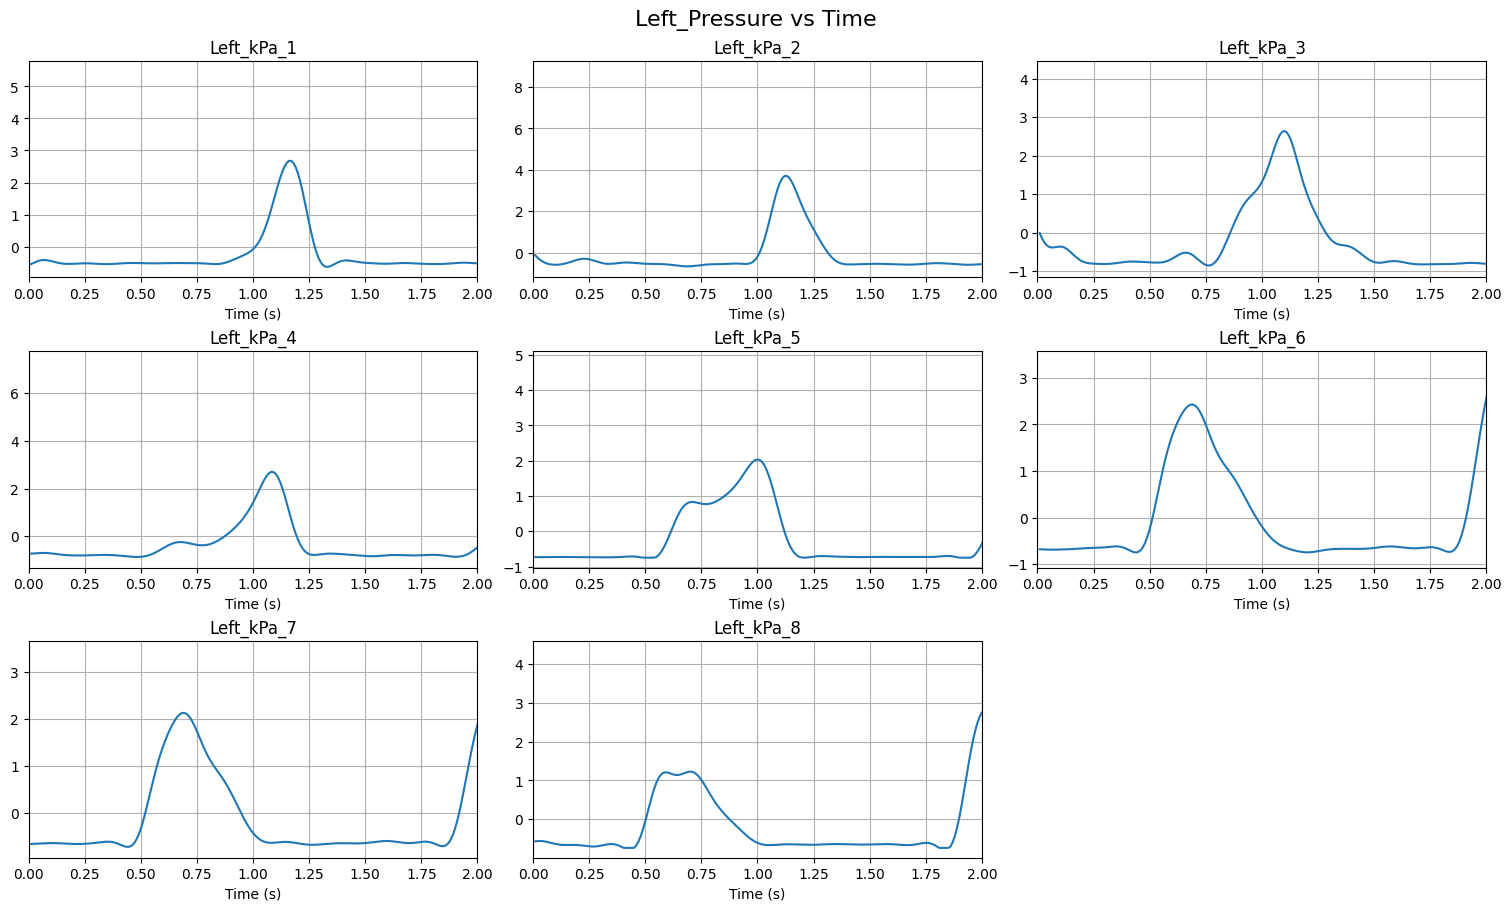

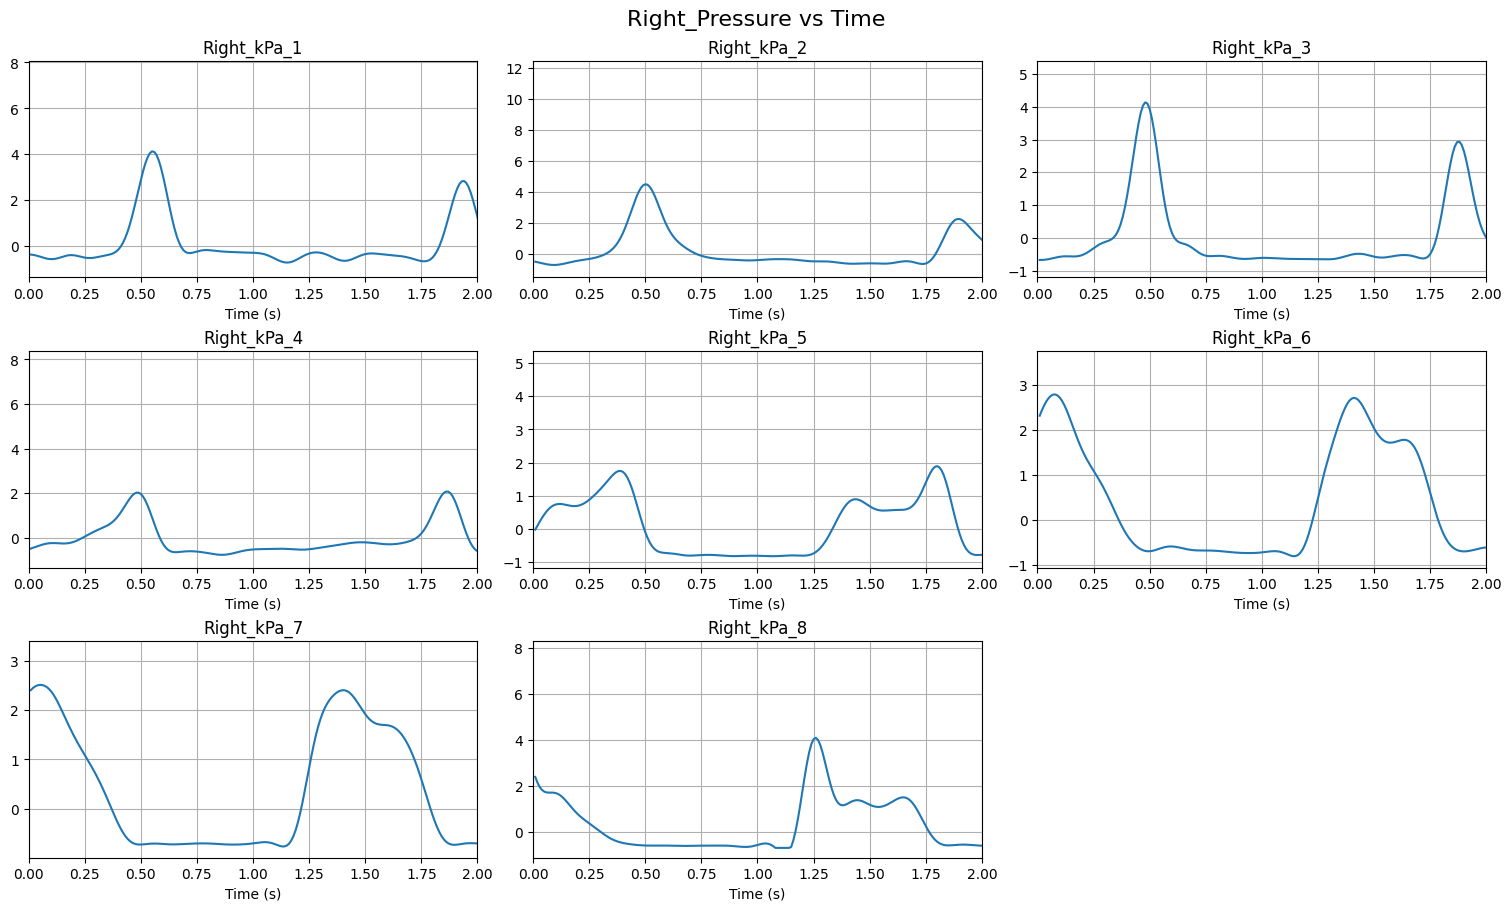

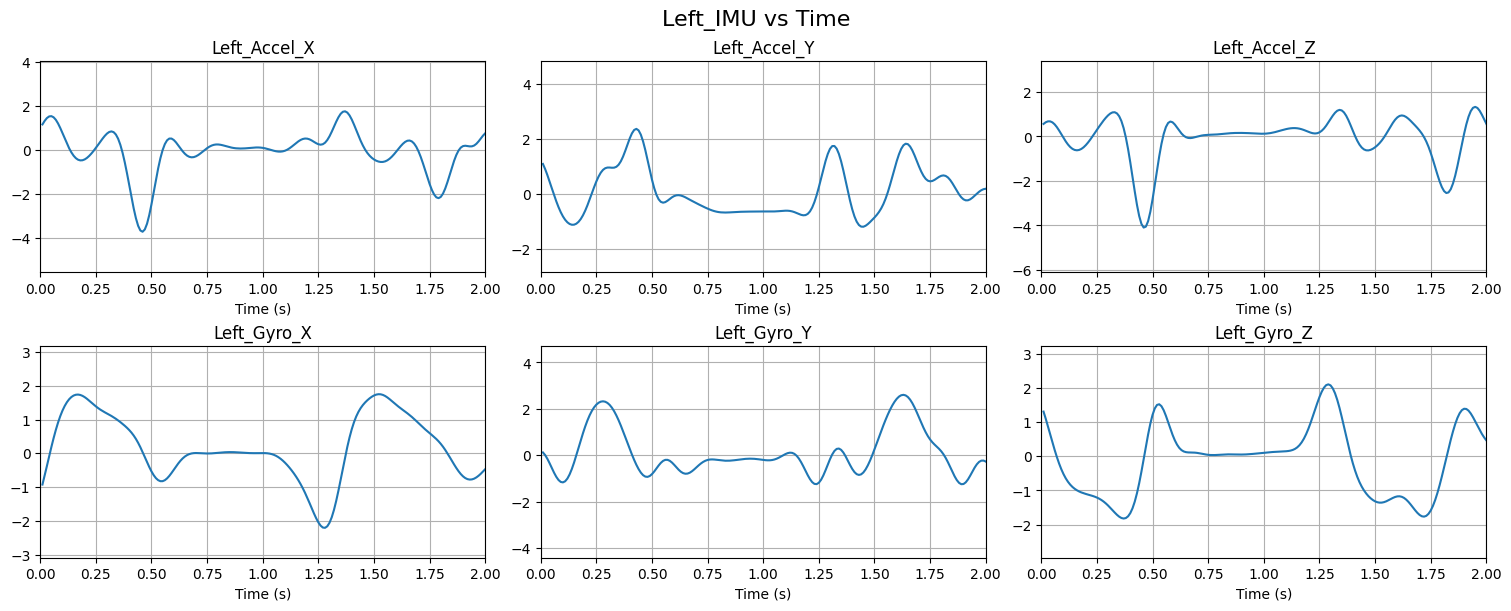

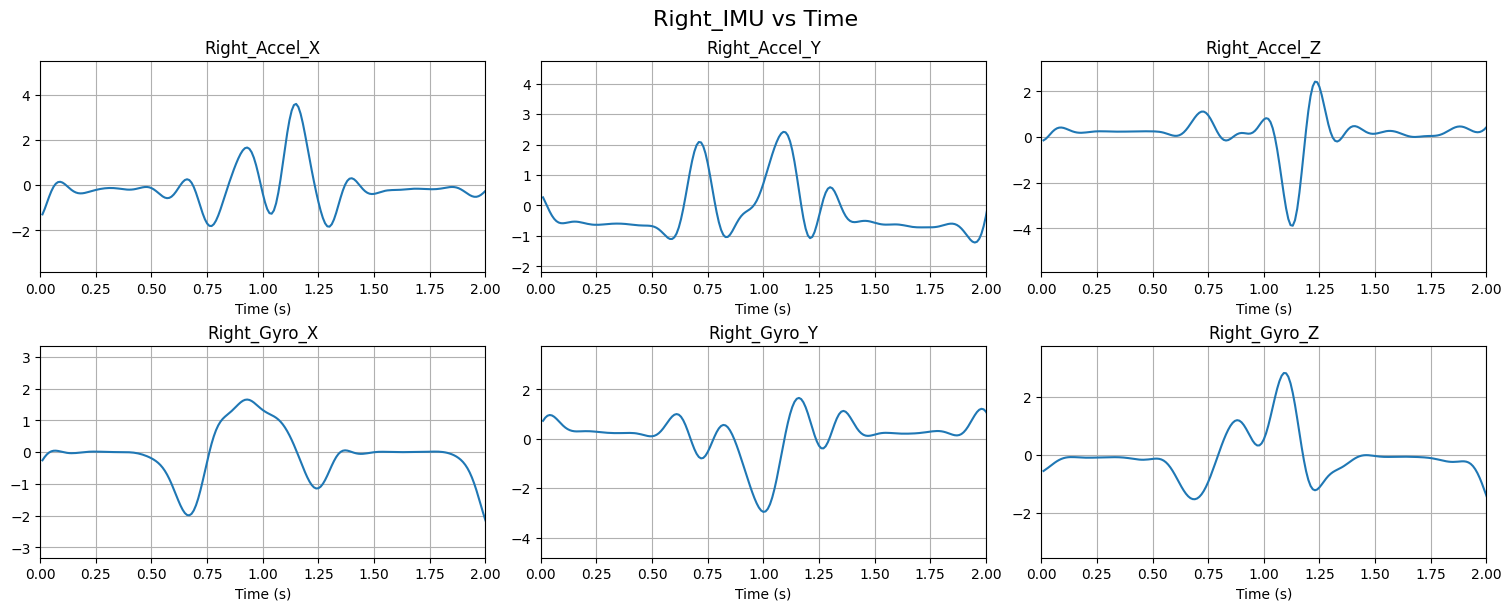

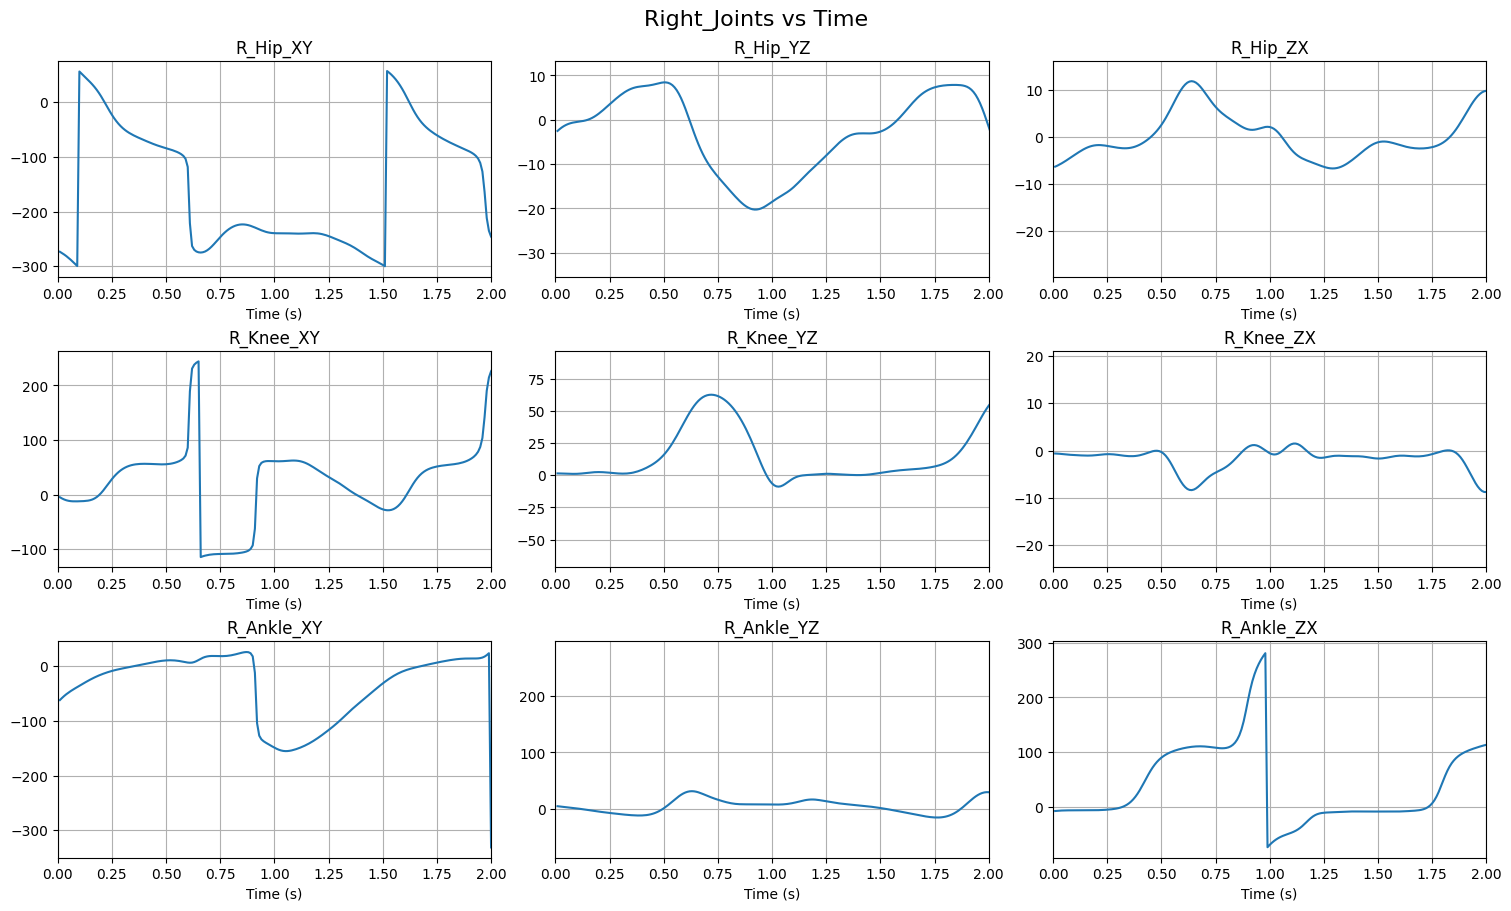

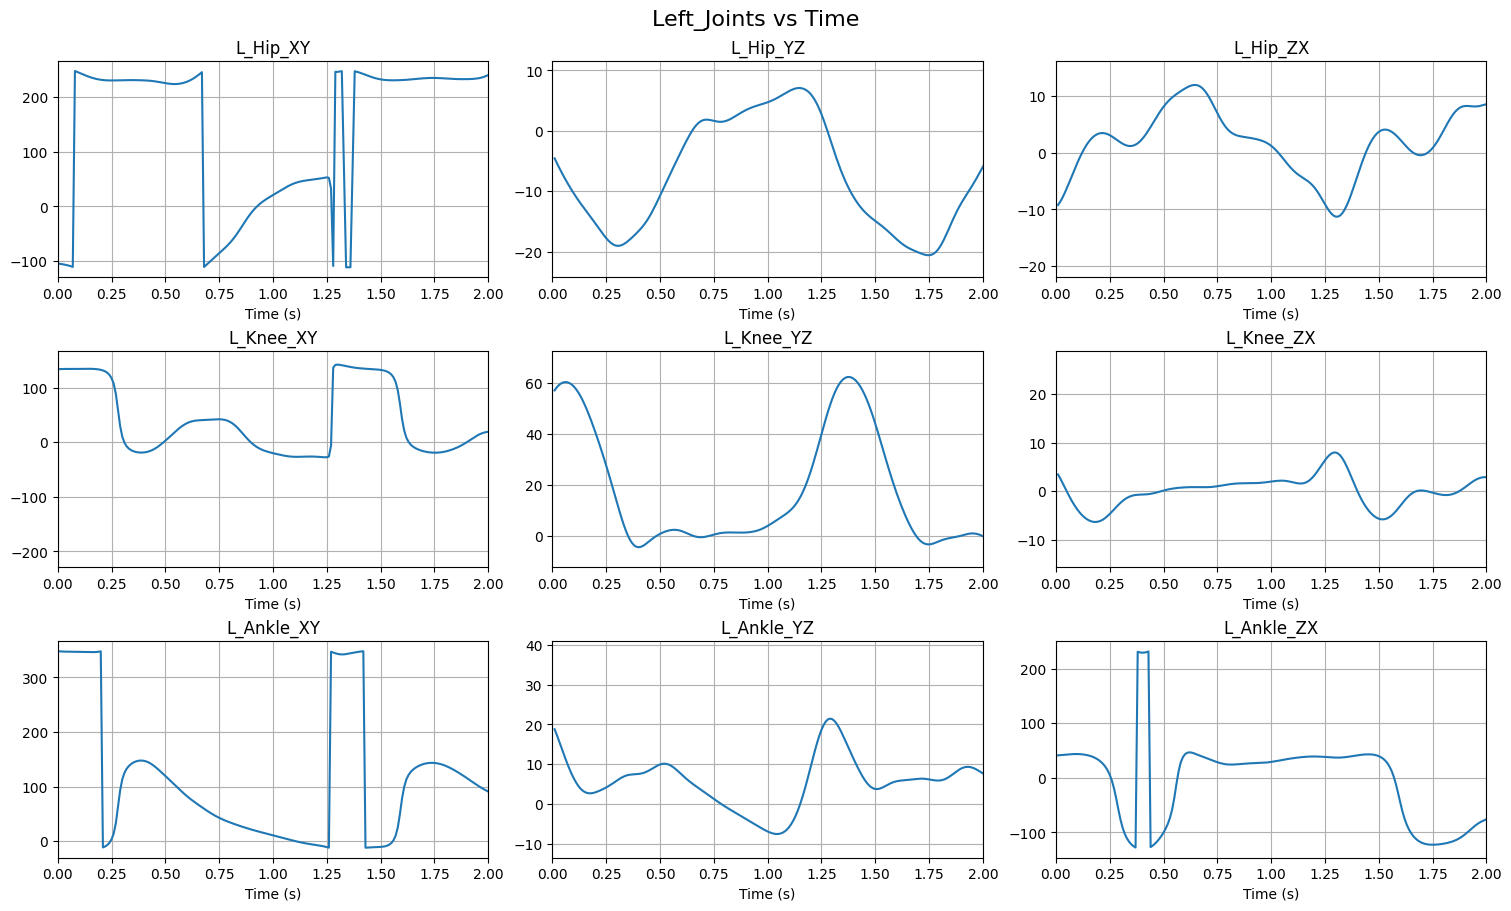

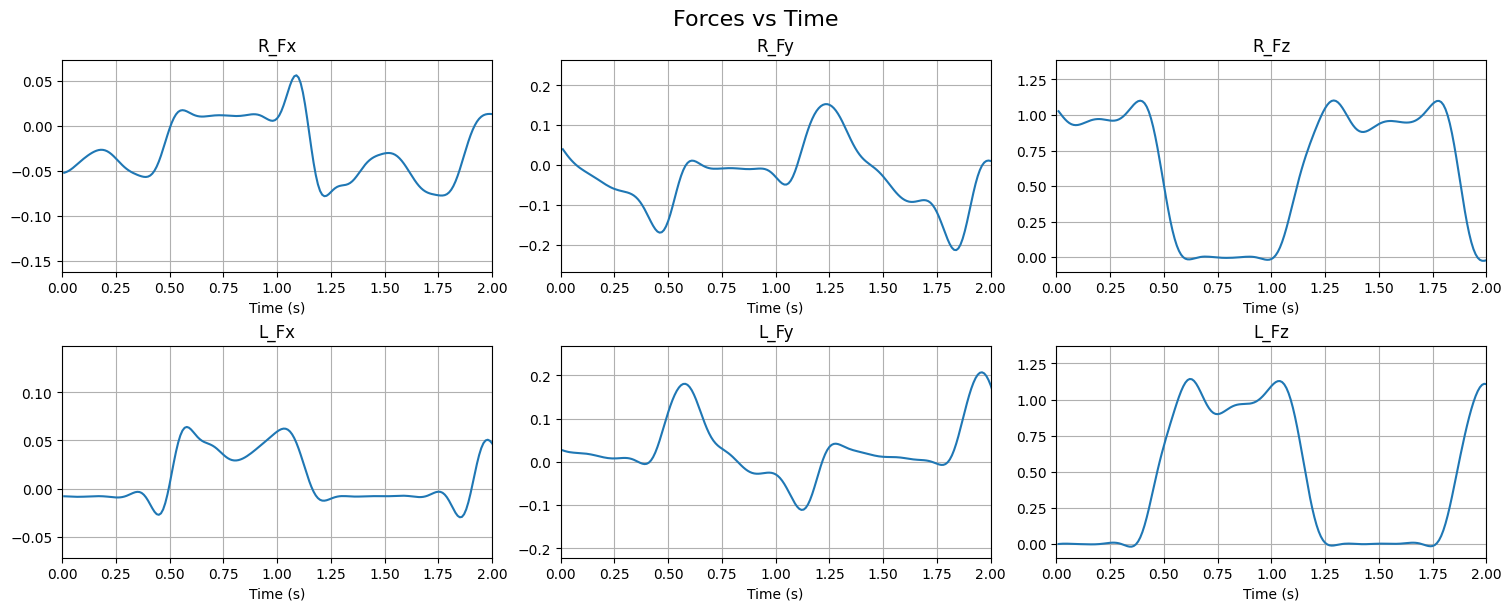

In [153]:
import math

# プロットのグループ定義
groups = {
    'Left_Pressure': [c for c in df_analysis.columns if 'Left_kPa' in c],
    'Right_Pressure': [c for c in df_analysis.columns if 'Right_kPa' in c],
    'Left_IMU': [c for c in df_analysis.columns if 'Left_Accel' in c or 'Left_Gyro' in c],
    'Right_IMU': [c for c in df_analysis.columns if 'Right_Accel' in c or 'Right_Gyro' in c],
    'Right_Joints': [c for c in df_analysis.columns if c.startswith('R_') and ('Hip' in c or 'Knee' in c or 'Ankle' in c)],
    'Left_Joints': [c for c in df_analysis.columns if c.startswith('L_') and ('Hip' in c or 'Knee' in c or 'Ankle' in c)],
    'Forces': [c for c in df_analysis.columns if '_F' in c]
}

# グループごとにグラフを作成
for group_name, cols in groups.items():
    n_cols = len(cols)
    if n_cols == 0: continue
    
    # レイアウト設定 (3列で折り返し)
    ncols_plot = 3
    nrows_plot = math.ceil(n_cols / ncols_plot)
    
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(15, 3 * nrows_plot), constrained_layout=True)
    fig.suptitle(f'{group_name} vs Time', fontsize=16)
    
    # axesが1次元配列でない場合の対応 (1行の場合など)
    if nrows_plot * ncols_plot > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, col in enumerate(cols):
        ax = axes[i]
        ax.plot(df_analysis['Time (Seconds)'], df_analysis[col])
        ax.set_title(col)
        ax.set_xlabel('Time (s)')
        ax.set_xlim(0,2)
        ax.grid(True)
    
    # 余ったサブプロット領域を非表示にする
    for i in range(n_cols, len(axes)):
        axes[i].axis('off')
        
    plt.show()


[Left] Processing Result:
  Total Detections : 210
  Accepted Strides : 180 (Range: 0.7-1.8s)
  Rejected Strides : 30
  -> Rejected Durations (sec): [np.float64(2.94), np.float64(2.61), np.float64(0.48), np.float64(2.73), np.float64(0.44), np.float64(2.67), np.float64(2.47), np.float64(2.59), np.float64(0.41), np.float64(0.42), np.float64(2.6), np.float64(2.07), np.float64(2.8), np.float64(3.67), np.float64(2.44), np.float64(2.38), np.float64(2.58), np.float64(2.26), np.float64(0.48), np.float64(0.47), np.float64(2.34), np.float64(3.18), np.float64(4.28), np.float64(0.54), np.float64(2.83), np.float64(2.59), np.float64(2.16), np.float64(5.8), np.float64(2.47), np.float64(3.54)]


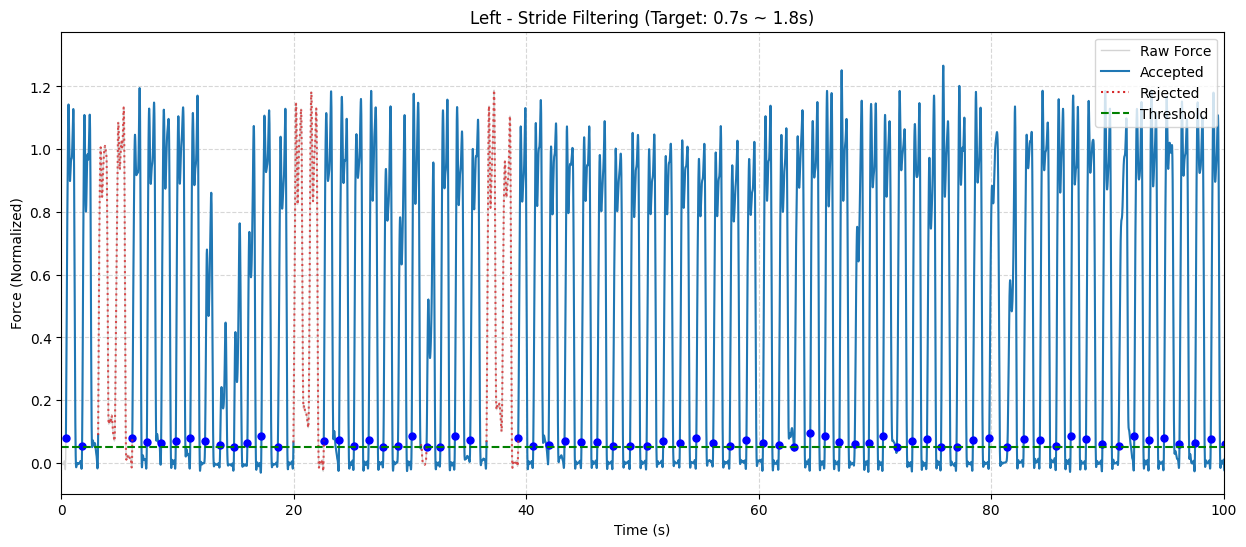


[Right] Processing Result:
  Total Detections : 215
  Accepted Strides : 202 (Range: 0.7-1.8s)
  Rejected Strides : 13
  -> Rejected Durations (sec): [np.float64(6.15), np.float64(2.5), np.float64(2.52), np.float64(2.52), np.float64(2.44), np.float64(2.41), np.float64(2.39), np.float64(2.54), np.float64(2.41), np.float64(2.34), np.float64(2.29), np.float64(3.56), np.float64(2.4)]


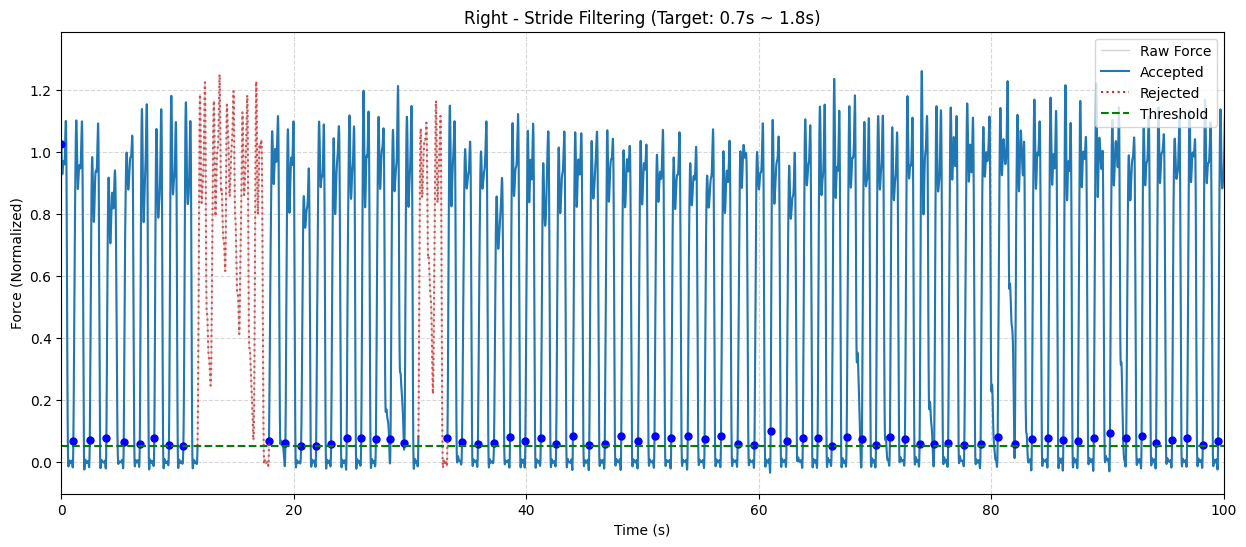

In [154]:
def detect_fz_heel_strikes(signal_array, threshold=0.05, min_dist_samples=40):
    """
    Fzの立ち上がり検出 (変更なし)
    """
    is_contact = signal_array > threshold
    rising_edge = np.diff(is_contact.astype(int), prepend=0) == 1
    potential_indices = np.where(rising_edge)[0]
    
    if len(potential_indices) == 0:
        return np.array([])

    true_indices = [potential_indices[0]]
    for idx in potential_indices[1:]:
        if idx - true_indices[-1] > min_dist_samples:
            true_indices.append(idx)
            
    return np.array(true_indices)

def slice_strides_with_constraints(df_input, target_col, side_name="Left", 
                                   threshold=0.05, fs=100, 
                                   min_duration=0.7, max_duration=1.8, 
                                   show_plot=True):
    """
    ストライド時間の制約を満たす歩行のみを抽出し、
    除外された長さはコンソールにのみ表示する関数
    """
    signal = df_input[target_col].values
    time_array = df_input['Time (Seconds)'].values
    
    min_dist_samples = int(0.4 * fs)
    
    # 1. 接地候補を検出
    hs_indices = detect_fz_heel_strikes(signal, threshold=threshold, min_dist_samples=min_dist_samples)
    
    valid_strides = []      # 採用リスト
    rejected_intervals = [] # 除外リスト (start, end, duration)
    valid_intervals = []    # 採用区間情報 (start, end)

    # 2. ストライドごとに時間を測ってフィルタリング
    for i in range(len(hs_indices) - 1):
        start_idx = hs_indices[i]
        end_idx = hs_indices[i+1]
        
        start_t = time_array[start_idx]
        end_t = time_array[end_idx]
        duration = end_t - start_t
        
        # --- 判定ロジック ---
        if min_duration <= duration <= max_duration:
            # 採用
            stride_df = df_input.iloc[start_idx:end_idx].copy()
            valid_strides.append(stride_df)
            valid_intervals.append((start_t, end_t))
        else:
            # 不採用
            rejected_intervals.append((start_t, end_t, duration))

    # --- 結果の表示 (コンソール) ---
    print(f"\n[{side_name}] Processing Result:")
    print(f"  Total Detections : {len(hs_indices)-1}")
    print(f"  Accepted Strides : {len(valid_strides)} (Range: {min_duration}-{max_duration}s)")
    print(f"  Rejected Strides : {len(rejected_intervals)}")
    
    if rejected_intervals:
        # 除外された秒数をリスト化して表示
        rej_durations = [round(r[2], 3) for r in rejected_intervals]
        print(f"  -> Rejected Durations (sec): {rej_durations}")

    # --- 結果の可視化 (プロット) ---
    if show_plot and len(hs_indices) > 0:
        plt.figure(figsize=(15, 6))
        
        # 全体波形
        plt.plot(time_array, signal, color='lightgray', label='Raw Force', linewidth=1)
        
        # 採用区間 (青)
        for (t_s, t_e) in valid_intervals:
            mask = (time_array >= t_s) & (time_array <= t_e)
            plt.plot(time_array[mask], signal[mask], color='tab:blue', linewidth=1.5)
            # 開始点
            idx_s = np.searchsorted(time_array, t_s)
            plt.plot(t_s, signal[idx_s], 'bo', markersize=5)

        # 除外区間 (赤・点線) - テキストは表示しない
        for (t_s, t_e, dur) in rejected_intervals:
            mask = (time_array >= t_s) & (time_array <= t_e)
            plt.plot(time_array[mask], signal[mask], color='tab:red', linestyle=':', alpha=0.8)

        # 凡例・ラベル
        plt.plot([], [], color='tab:blue', label='Accepted')
        plt.plot([], [], color='tab:red', linestyle=':', label='Rejected')
        plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')

        plt.title(f"{side_name} - Stride Filtering (Target: {min_duration}s ~ {max_duration}s)")
        plt.xlabel("Time (s)")
        plt.ylabel("Force (Normalized)")
        plt.legend(loc='upper right')
        
        # 最初の30秒を表示
        display_end = min(time_array[-1], time_array[0] + 30)
        plt.xlim(0,100)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return valid_strides

# ==========================================
# 実行
# ==========================================
FORCE_THRESHOLD = 0.05

# 左足
left_strides_clean = slice_strides_with_constraints(
    df_input=df_analysis,
    target_col='L_Fz',
    side_name="Left",
    threshold=FORCE_THRESHOLD,
    show_plot=True
)

# 右足
right_strides_clean = slice_strides_with_constraints(
    df_input=df_analysis,
    target_col='R_Fz',
    side_name="Right",
    threshold=FORCE_THRESHOLD,
    show_plot=True
)

[Left Foot] Target Window: 30.06s - 330.06s
  > Detected 233 steps.


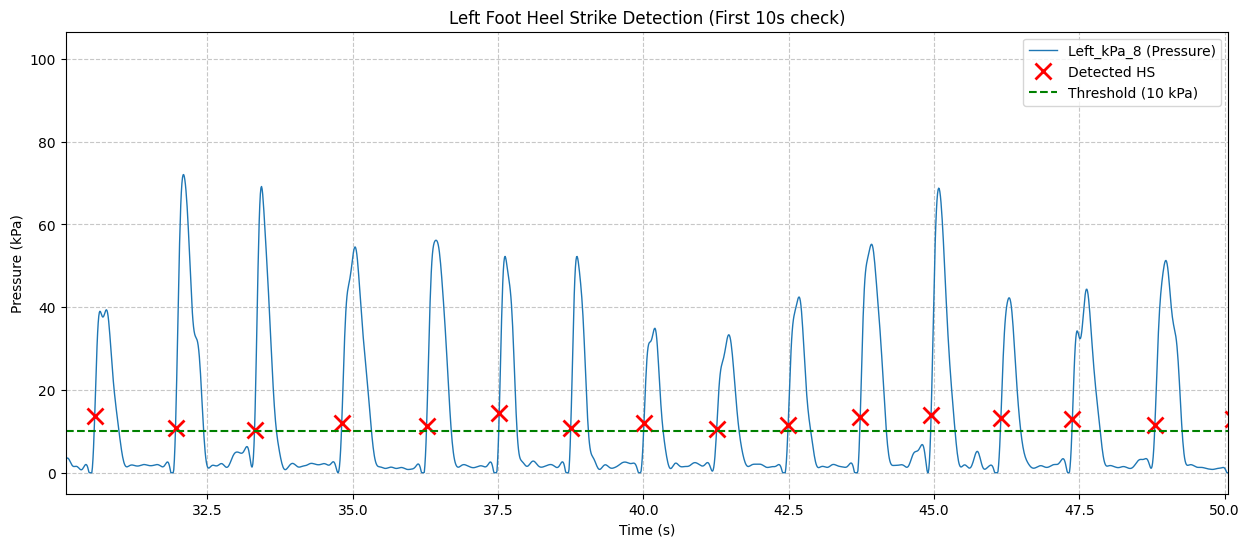

[Right Foot] Target Window: 30.07s - 330.07s
  > Detected 233 steps.


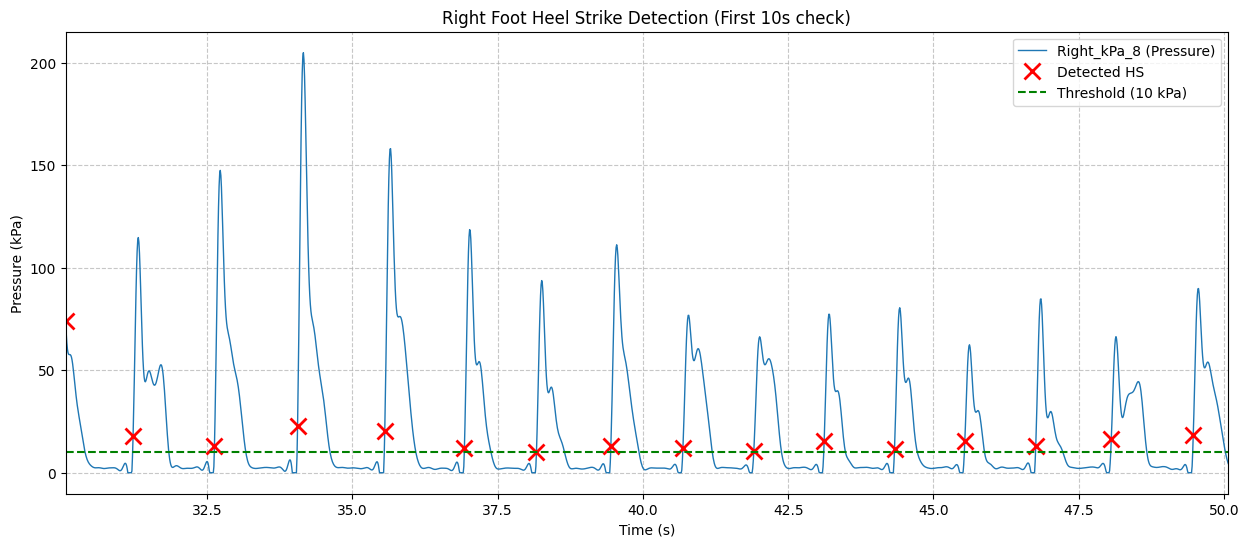

In [155]:
def detect_heel_strikes(signal_array, threshold=10, min_dist_samples=40):
    """
    踵接地 (HS) のタイミング（インデックス）を検出する関数
    
    Parameters:
    - signal_array: 踵の圧力データの配列 (numpy array)
    - threshold: 接地とみなす閾値 (kPa)。ノイズより大きく設定。
    - min_dist_samples: 次の接地までの最小サンプル数 (不応期)。
                        100Hzで0.4秒なら40サンプル。
    
    Returns:
    - indices: 接地開始タイミングのインデックス配列
    """
    # 閾値を超えている場所をTrue, それ以外をFalseにする
    is_contact = signal_array > threshold
    
    # False(浮いている) -> True(着いた) に切り替わる瞬間を検出 (立ち上がりエッジ)
    # diffをとると、立ち上がりは 1 (True), 立ち下がりは -1, 変化なしは 0
    # prepend=False で配列サイズを合わせる
    rising_edge = np.diff(is_contact.astype(int), prepend=0) == 1
    
    # 候補となるインデックスを取得
    potential_indices = np.where(rising_edge)[0]
    
    if len(potential_indices) == 0:
        return np.array([])

    # --- 不応期（チャタリング除去）処理 ---
    # 直前の検出から min_dist_samples 以内の検出は無視する
    true_indices = [potential_indices[0]]
    
    for idx in potential_indices[1:]:
        if idx - true_indices[-1] > min_dist_samples:
            true_indices.append(idx)
            
    return np.array(true_indices)

def slice_strides(df_target, split_indices):
    """
    インデックスに基づいてデータフレームを分割し、リストに格納する関数
    
    Parameters:
    - df_target: 分割したいデータフレーム (Zスコア化済みデータなど)
    - split_indices: 接地点のインデックス配列
    
    Returns:
    - stride_list: 分割されたデータフレームのリスト
    """
    strides = []
    
    # インデックス間のデータを切り出す
    # 例: idx[0]〜idx[1], idx[1]〜idx[2], ...
    for i in range(len(split_indices) - 1):
        start_idx = split_indices[i]
        end_idx = split_indices[i+1]
        
        # スライス (コピーを作成しておく)
        stride_df = df_target.iloc[start_idx:end_idx].copy()
        
        # 1ストライドの時間軸を0からスタートするようにリセットする場合
        # stride_df['Time (Seconds)'] = stride_df['Time (Seconds)'] - stride_df['Time (Seconds)'].iloc[0]
        
        strides.append(stride_df)
        
    return strides

def extract_strides_in_window(df_smooth, df_z, heel_col, duration=300, threshold=10, min_dist_sec=0.6, fs=100, show_plot=True, title_prefix=""):
    """
    Marker開始から300秒間を切り出し、ストライド分割を行う関数 (プロット機能付き)

    Parameters:
    - df_smooth: 接地検出用のデータ (平滑化済み, kPa単位)
    - df_z:     出力用のデータ (Zスコア化済み)
    - heel_col: 踵の圧力カラム名
    - duration: 切り出す期間 (秒)
    
    Returns:
    - stride_list: 分割された1歩ごとのDataFrameリスト (Zスコア化データ)

    """
    
    # 1. マーカー開始時刻の特定
    marker_cols = [c for c in df_smooth.columns if 'Marker' in c]
    if not marker_cols:
        print("Error: No marker column found.")
        return []
    
    valid_markers = df_smooth[['Time (Seconds)'] + marker_cols].dropna(subset=marker_cols, how='all')
    if valid_markers.empty:
        print("Error: Marker never appears.")
        return []
        
    start_time = valid_markers.iloc[1]['Time (Seconds)']
    end_time = start_time + duration
    
    print(f"[{title_prefix}] Target Window: {start_time:.2f}s - {end_time:.2f}s")
    
    # 2. 300秒間だけデータを切り出す
    mask = (df_smooth['Time (Seconds)'] >= start_time) & (df_smooth['Time (Seconds)'] <= end_time)
    
    # indexをリセット (0行目 = 切り出し開始地点)
    df_crop_smooth = df_smooth.loc[mask].reset_index(drop=True)
    df_crop_z      = df_z.loc[mask].reset_index(drop=True)
    
    if df_crop_smooth.empty:
        print("Warning: Cropped dataframe is empty.")
        return []

    # 3. 接地タイミングを検出
    heel_signal = df_crop_smooth[heel_col].values
    min_dist_samples = int(min_dist_sec * fs)
    
    hs_indices = detect_heel_strikes(heel_signal, threshold=threshold, min_dist_samples=min_dist_samples)
    print(f"  > Detected {len(hs_indices)} steps.")
    
    # --- ★追加: 確認用プロット ---
    if show_plot and len(hs_indices) > 0:
        plt.figure(figsize=(15, 6))
        
        # 踵の圧力波形
        time_axis = df_crop_smooth['Time (Seconds)']
        # 切り出し後の相対時間にするなら以下を有効化
        # time_axis = time_axis - time_axis.iloc[0] 
        
        plt.plot(time_axis, heel_signal, label=f'{heel_col} (Pressure)', color='tab:blue', linewidth=1)
        
        # 検出ポイントを赤×でプロット
        plt.plot(time_axis.iloc[hs_indices], 
                 heel_signal[hs_indices], 
                 'rx', markersize=12, markeredgewidth=2, label='Detected HS')
        
        # 閾値ライン
        plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold} kPa)')
        
        plt.title(f"{title_prefix} Heel Strike Detection (First 10s check)")
        plt.xlabel("Time (s)")
        plt.ylabel("Pressure (kPa)")
        plt.legend(loc='upper right')
        
        # 見やすいように最初の10秒だけ拡大 (データがあれば)
        plot_start = time_axis.iloc[0]
        plot_end = min(time_axis.iloc[-1], plot_start + 20) # 最初の10秒、あるいはデータの終わりまで
        plt.xlim(plot_start, plot_end)
        
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

    # 4. 分割
    stride_list = slice_strides(df_crop_z, hs_indices)
    
    return stride_list

# ==========================================
# 実行 (プロットが表示されます)
# ==========================================

LEFT_HEEL_COL = 'Left_kPa_8'   
RIGHT_HEEL_COL = 'Right_kPa_8'

# 左足の処理と確認
left_strides = extract_strides_in_window(
    df_smooth=df_left_smoothed, 
    df_z=df_left_z, 
    heel_col=LEFT_HEEL_COL,
    show_plot=True,         # ★これでグラフが出ます
    title_prefix="Left Foot"
)

# 右足の処理と確認
right_strides = extract_strides_in_window(
    df_smooth=df_right_smoothed, 
    df_z=df_right_z, 
    heel_col=RIGHT_HEEL_COL,
    show_plot=True,         # ★これでグラフが出ます
    title_prefix="Right Foot"
)

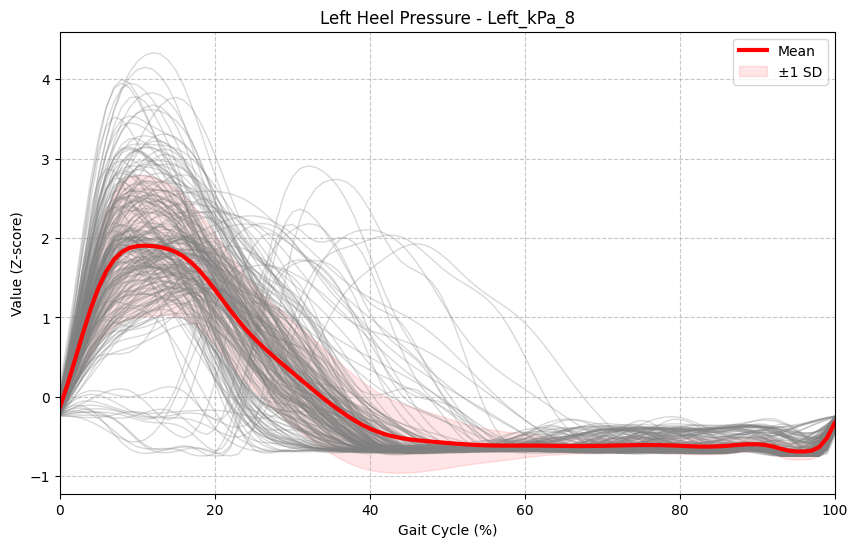

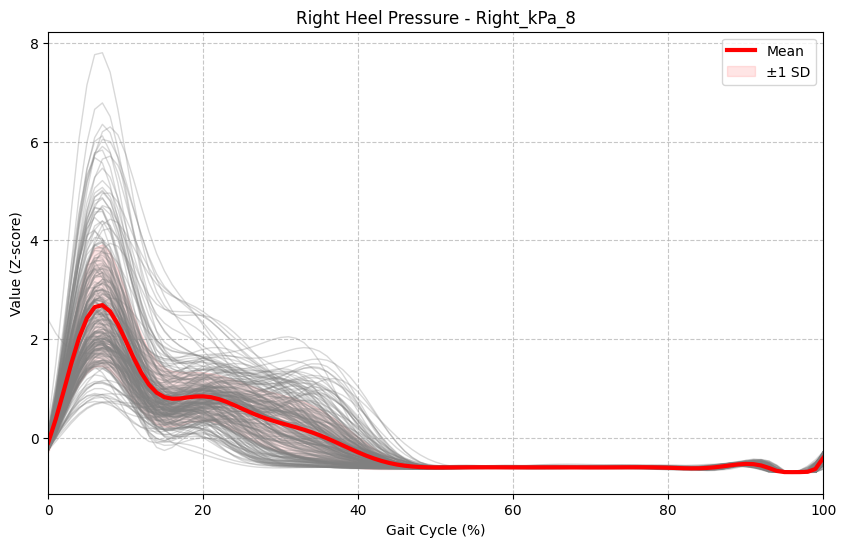

In [156]:
def plot_ensemble_strides(stride_list, target_col, title="Stride Ensemble", unit="Z-score"):
    """
    複数のストライドデータを0-100%に正規化して重ね書きする関数
    
    Parameters:
    - stride_list: 切り出されたDataFrameのリスト
    - target_col: プロットしたいカラム名 (例: 'Right_kPa_1' や 'Acc_X')
    - title: グラフのタイトル
    - unit: Y軸の単位ラベル
    """
    if not stride_list:
        print("No strides to plot.")
        return

    # 正規化後のデータ点数 (0% ~ 100% を 101分割)
    norm_length = 101
    x_norm = np.linspace(0, 100, norm_length)
    
    # データを蓄積するリスト
    ensemble_data = []

    plt.figure(figsize=(10, 6))

    # --- 1. 個別のストライドをプロット ---
    for df in stride_list:
        # 対象カラムのデータを取得
        y_values = df[target_col].values
        
        # データの長さが足りない場合はスキップ（念のため）
        if len(y_values) < 2:
            continue

        # 時間軸の正規化 (線形補間を使ってデータ点数をnorm_lengthに揃える)
        # 元の配列のインデックスを 0~100 にマッピング
        x_original = np.linspace(0, 100, len(y_values))
        y_interp = np.interp(x_norm, x_original, y_values)
        
        ensemble_data.append(y_interp)

        # 薄いグレーでプロット
        plt.plot(x_norm, y_interp, color='gray', alpha=0.3, linewidth=1)

    # --- 2. 平均波形の計算とプロット ---
    if ensemble_data:
        # numpy配列に変換 (行: ストライド数, 列: 101)
        ensemble_matrix = np.array(ensemble_data)
        
        # 平均と標準偏差を計算
        mean_waveform = np.mean(ensemble_matrix, axis=0)
        std_waveform = np.std(ensemble_matrix, axis=0)
        
        # 平均値を赤色でプロット
        plt.plot(x_norm, mean_waveform, color='red', linewidth=3, label='Mean')
        
        # (オプション) 標準偏差の範囲を塗りつぶし
        plt.fill_between(x_norm, 
                         mean_waveform - std_waveform, 
                         mean_waveform + std_waveform, 
                         color='red', alpha=0.1, label='±1 SD')

    # --- 3. グラフの装飾 ---
    plt.title(f"{title} - {target_col}")
    plt.xlabel("Gait Cycle (%)")
    plt.ylabel(f"Value ({unit})")
    plt.xlim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# ==========================================
# 実行例
# ==========================================
plot_ensemble_strides(
    stride_list=left_strides, 
    target_col='Left_kPa_8', 
    title="Left Heel Pressure",
    unit="Z-score"
)
plot_ensemble_strides(
    stride_list=right_strides, 
    target_col='Right_kPa_8', 
    title="Right Heel Pressure",
    unit="Z-score"
)

左足マーカー数: 2
[3.7, 30.06]
右足マーカー数: 2
[3.69, 30.07]


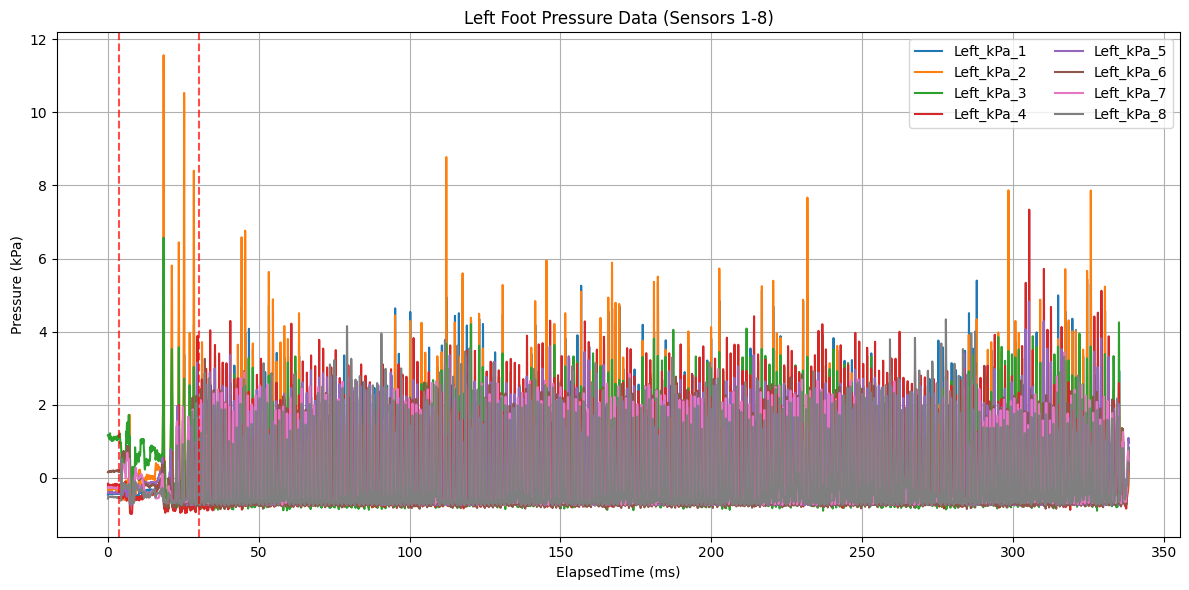

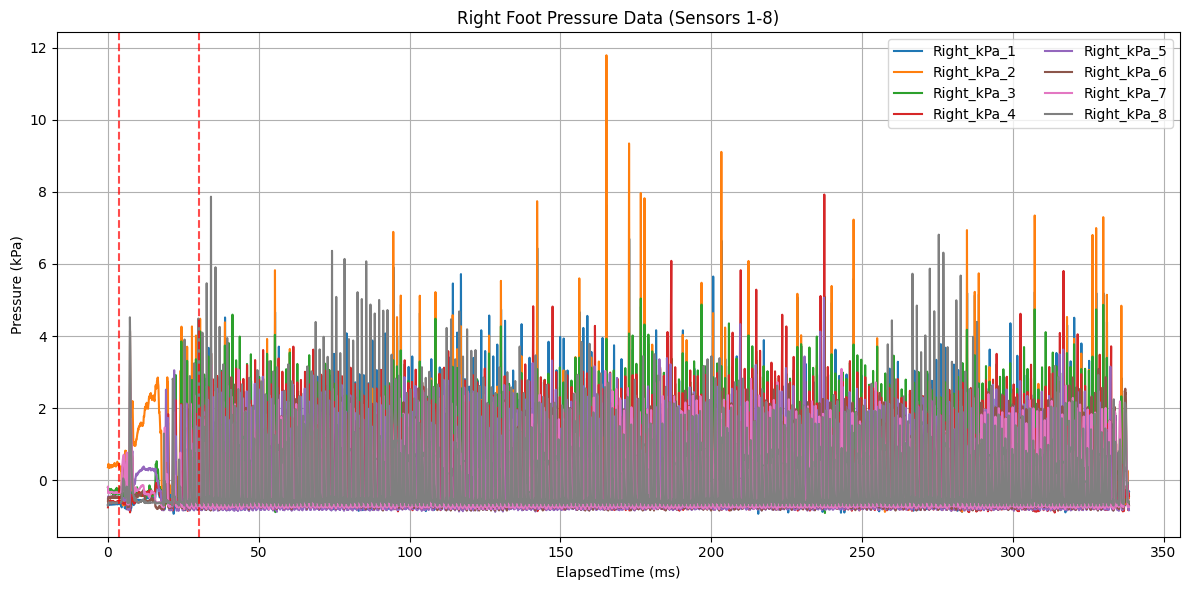

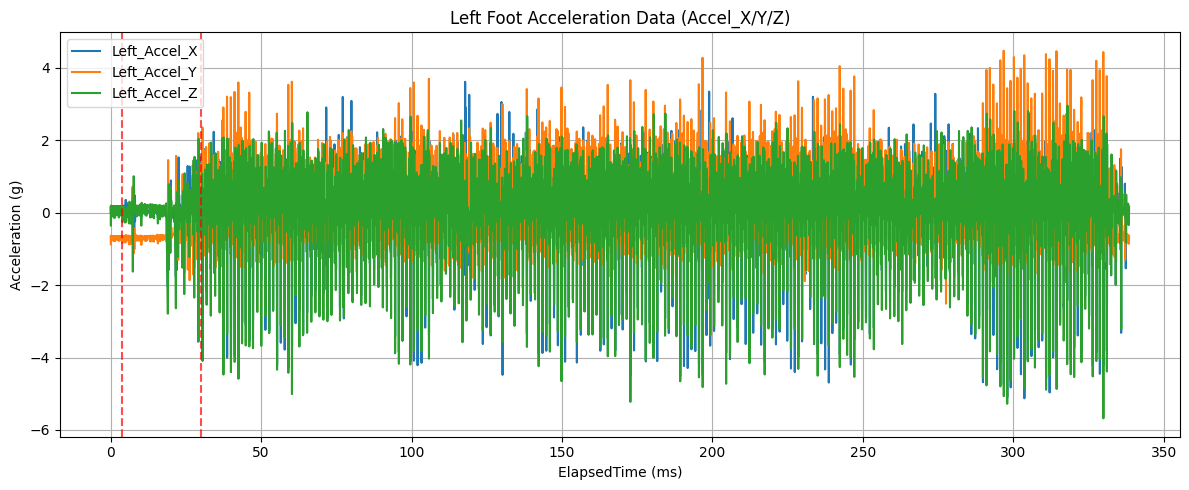

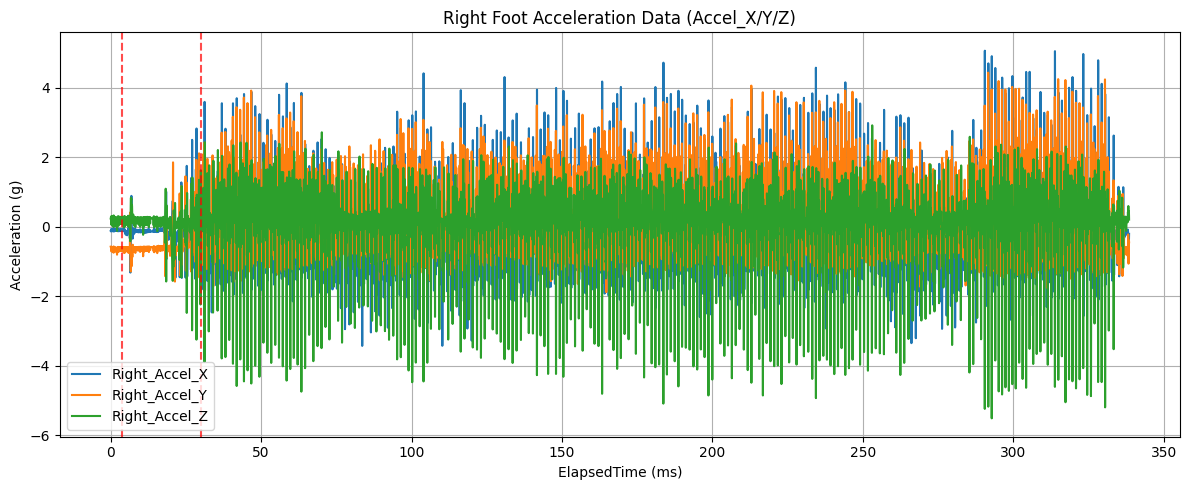

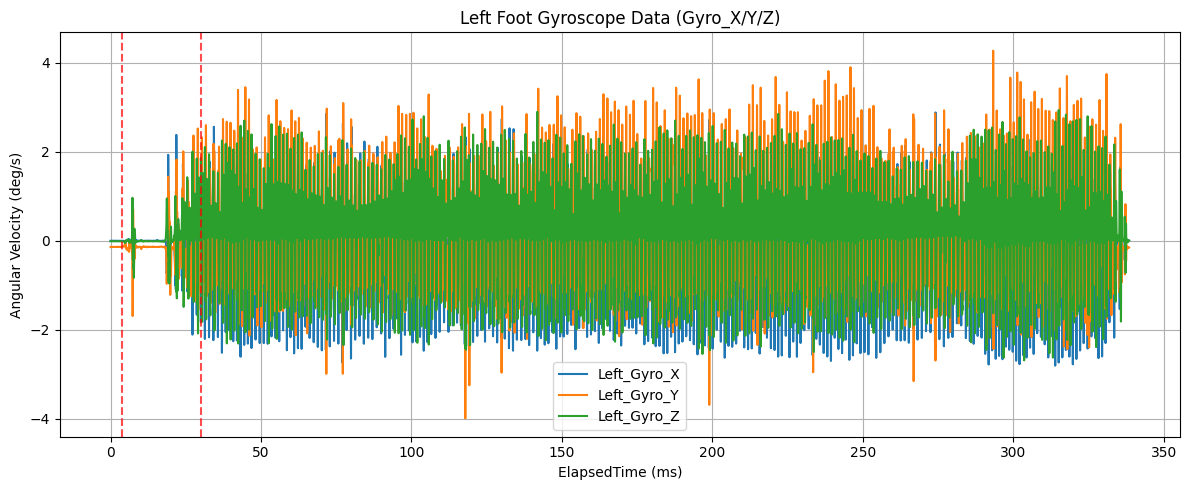

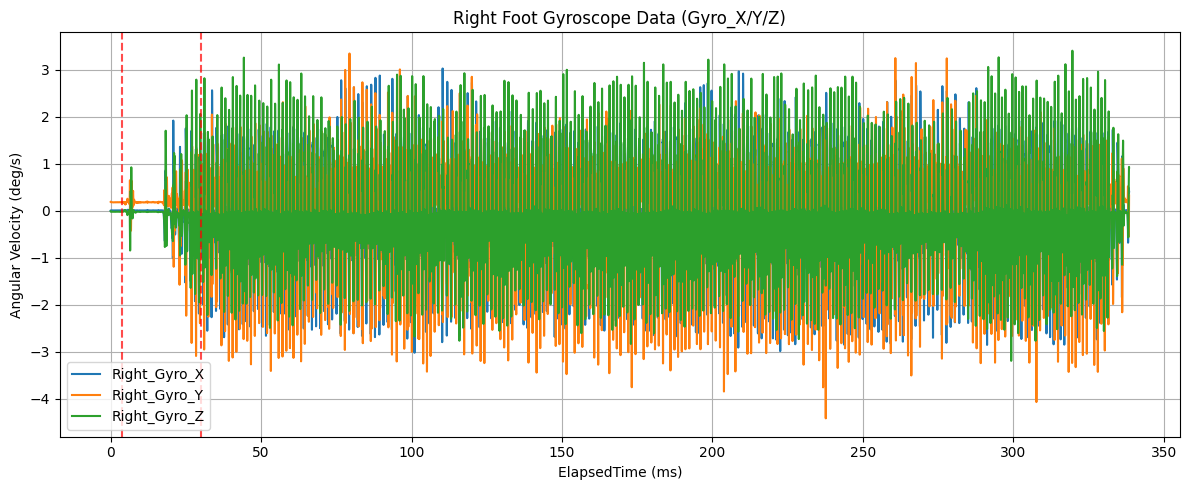

In [157]:
df_left = df_left_z
df_right = df_right_z

# 横軸：ElapsedTime
time_left = df_left['Time (Seconds)']
time_right = df_right['Time (Seconds)']

# マーカーが記録されている時刻を取得（0でない，かつNaNでない行）
marker_times_left = df_left[(df_left['Marker'].notna()) & (df_left['Marker'] != 0)]['Time (Seconds)']
marker_times_right = df_right[(df_right['Marker'].notna()) & (df_right['Marker'] != 0)]['Time (Seconds)']
print(f"左足マーカー数: {len(marker_times_left)}")
print(marker_times_left.tolist())
print(f"右足マーカー数: {len(marker_times_right)}")
print(marker_times_right.tolist())



# 1. 足圧センサーデータ（kPa_1～8）- 左足
kpa_cols = ['kPa_1', 'kPa_2', 'kPa_3', 'kPa_4', 'kPa_5', 'kPa_6', 'kPa_7', 'kPa_8']
plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
# plt.xlim(40000,50000)
plt.ylabel('Pressure (kPa)')
plt.title('Left Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 1. 足圧センサーデータ（kPa_1～8）- 右足
plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
# plt.xlim(40000,50000)
plt.ylabel('Pressure (kPa)')
plt.title('Right Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 左足
accel_cols = ['Accel_X', 'Accel_Y', 'Accel_Z']

plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Left Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 右足
plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Right Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 左足
gyro_cols = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']

plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Left Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 右足
plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Right Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()